<a href="https://colab.research.google.com/github/syedayazsa/transfer-learning-for-segregation/blob/master/VGG19_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING NECESSARY LIBRARIES**

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

# **LOADING AND UNZIPPING THE DATASET**

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-19 10:39:13--  https://docs.google.com/uc?export=download&confirm=kGL_&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 74.125.24.139, 74.125.24.138, 74.125.24.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-3k-docs.googleusercontent.com/docs/securesc/np7gtmqc0qf00bb4vu27htdujuoapgaf/se8mdc9fnjf7h186tds2m45mdknmppo1/1589884725000/14211000813324722452/09000535106330579421Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-19 10:39:13--  https://doc-0o-3k-docs.googleusercontent.com/docs/securesc/np7gtmqc0qf00bb4vu27htdujuoapgaf/se8mdc9fnjf7h186tds2m45mdknmppo1/1589884725000/14211000813324722452/09000535106330579421Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-0o-3k-docs.googleusercontent.com (doc-0o-3k-docs.googleusercontent.com)... 74.125.68.132, 2404:6800:4003:c02::84
Connecting to d

# **SPECIFIYING PATHS TO DIRECTORY**

In [21]:
base_path = '/content/split_dataset'

folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/bullet_shells', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/bottles', '/content/split_dataset/train/boots', '/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/knives', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/syringes']


In [0]:
IMAGE_SIZE = [224, 224]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED VGG**

In [0]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [0]:
x = Flatten()(vgg.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE VGG MODEL**

In [33]:
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [35]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [36]:
history_vgg = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=25,
  verbose = 1,
  steps_per_epoch=400,
  validation_steps=80
  )

Epoch 1/25
 18/400 [>.............................] - ETA: 4:44 - loss: 2.3292 - accuracy: 0.1441

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


400/400 [==============================] - 254s 635ms/step - loss: 1.6390 - accuracy: 0.3847 - val_loss: 0.9768 - val_accuracy: 0.6173
Epoch 2/25
400/400 [==============================] - 240s 601ms/step - loss: 0.9504 - accuracy: 0.6715 - val_loss: 0.8175 - val_accuracy: 0.7636
Epoch 3/25
400/400 [==============================] - 238s 595ms/step - loss: 0.7464 - accuracy: 0.7640 - val_loss: 0.5143 - val_accuracy: 0.8468
Epoch 4/25
400/400 [==============================] - 236s 590ms/step - loss: 0.6442 - accuracy: 0.8037 - val_loss: 0.5546 - val_accuracy: 0.8566
Epoch 5/25
400/400 [==============================] - 235s 587ms/step - loss: 0.6059 - accuracy: 0.8142 - val_loss: 0.4447 - val_accuracy: 0.8641
Epoch 6/25
400/400 [==============================] - 237s 592ms/step - loss: 0.5505 - accuracy: 0.8352 - val_loss: 0.4242 - val_accuracy: 0.8539
Epoch 7/25
400/400 [==============================] - 237s 593ms/step - loss: 0.5259 - accuracy: 0.8476 - val_loss: 0.5533 - val_accura

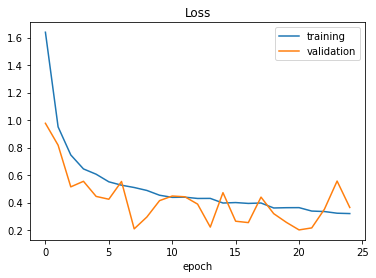

In [37]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

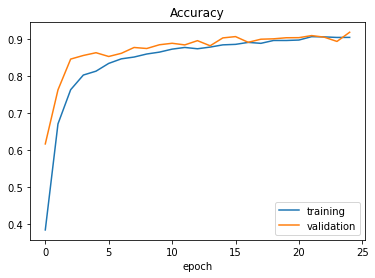

In [38]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

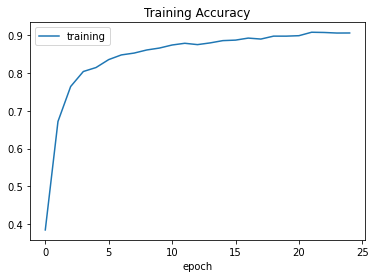

In [41]:
plt.plot(history_vgg.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('epoch')
plt.legend(['training'])

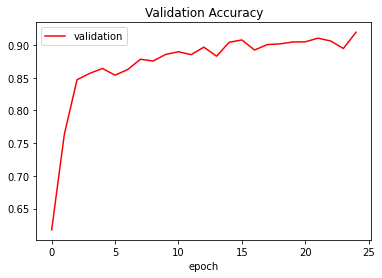

In [43]:
plt.plot(history_vgg.history['val_accuracy'], color = 'r')
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(['validation'])

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls gdrive

'My Drive'


In [0]:
model_vgg.save('/content/gdrive/My Drive/Model/vgg19.h5')

In [0]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle